In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print(df.shape)
df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### I already do some data visualization and create machine learning model in the previous kaggle notebook, if you want to see that, please go to my personal page and click the **Credit Card Fraud with Catboost** notebook.

### SMOTE
Since it's imbalanced data, we use SMOTE for oversampling and random combine undersampling.

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
X = df.drop(['Class','Time'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

In [5]:
# apply SMOTE
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o',over), ('u', under)]
pipline = Pipeline(steps=steps)

In [6]:
X_resample, y_resample = pipline.fit_resample(X_train, y_train)
y_resample.value_counts(normalize=True)

0    0.5
1    0.5
Name: Class, dtype: float64

In [28]:
print(X_resample.shape)
print(X_test.shape)
print(y_resample.shape)
print(y_test.shape)

(227450, 29)
(56962, 29)
(227450,)
(56962,)


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_resample_scaled = scaler.fit_transform(X_resample)
X_test_scaled = scaler.transform(X_test)

#### now we have the balanced data
then, use two method two evaluate
1. Isolation Forest
2. One-Class svm

In [24]:
# apply Isolation Forest and One-class SVM to evaluate resample data
from sklearn.ensemble import IsolationForest

iso = IsolationForest(n_estimators=200, random_state=42)
iso.fit(X_resample_scaled)
y_pred_iso = iso.predict(X_test_scaled)
y_pred_iso = [1 if x ==-1 else 0 for x in y_pred_iso] #change the result (-1,1) to (1,0)
y_score_iso = iso.decision_function(X_test_scaled)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.04      0.27      0.07        98

    accuracy                           0.99     56962
   macro avg       0.52      0.63      0.53     56962
weighted avg       1.00      0.99      0.99     56962



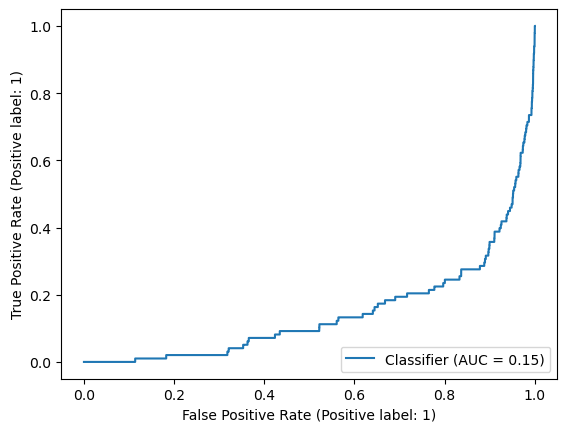

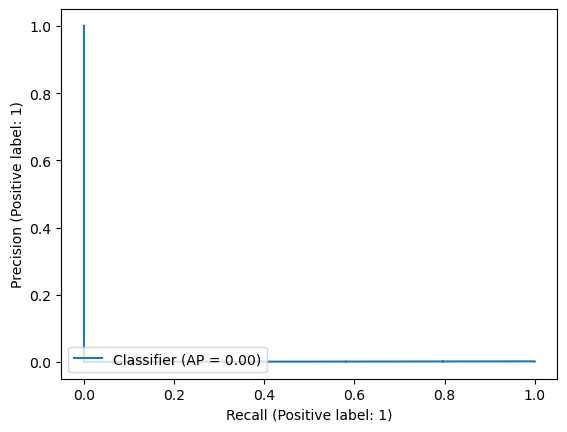

In [25]:
print(classification_report(y_test, y_pred_iso))
RocCurveDisplay.from_predictions(y_test, y_score_iso)
PrecisionRecallDisplay.from_predictions(y_test, y_score_iso)

In [36]:
from sklearn.svm import OneClassSVM
one_class_svm = OneClassSVM(kernel='rbf', nu=0.01)
one_class_svm.fit(X_resample_scaled)
y_pred_svm = one_class_svm.predict(X_test_scaled)
y_pred_svm = [1 if x == -1 else 0 for x in y_pred_svm]
y_score_svm = one_class_svm.decision_function(X_test_scaled)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.02      0.14      0.03        98

    accuracy                           0.99     56962
   macro avg       0.51      0.57      0.51     56962
weighted avg       1.00      0.99      0.99     56962



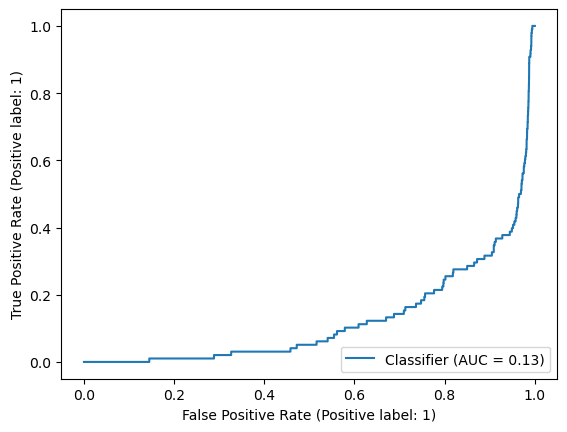

In [37]:
print(classification_report(y_test, y_pred_svm))
RocCurveDisplay.from_predictions(y_test, y_score_svm)

#### Still finding some method to improve
1. LOF
2. DBSCAN

In [47]:
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor for Anomaly Detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = lof.fit_predict(X_resample_scaled)
y_score_lof = lof.negative_outlier_factor_
y_pred_lof_test = lof.fit_predict(X_test_scaled)
y_pred_lof_test = [1 if x == -1 else 0 for x in y_pred_lof_test]  # Convert to 0 for 'normal' and 1 for 'anomaly'
print(classification_report(y_test, y_pred_lof_test))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.01      0.54      0.02        98

    accuracy                           0.90     56962
   macro avg       0.50      0.72      0.48     56962
weighted avg       1.00      0.90      0.95     56962



In [11]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# DBSCAN for Anomaly Detection
db = DBSCAN(eps=0.5, min_samples=5)
db.fit(X_resample_scaled)
y_pred_db_test = db.fit_predict(X_test_scaled)
y_pred_db_test = [1 if x == -1 else 0 for x in y_pred_db_test]  # Convert to 0 for 'normal' and 1 for 'anomaly'


In [13]:
print(classification_report(y_test, y_pred_db_test))

              precision    recall  f1-score   support

           0       1.00      0.21      0.34     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.21     56962
   macro avg       0.50      0.60      0.17     56962
weighted avg       1.00      0.21      0.34     56962



## Alright, let's try AutoEncoder

#### Since it's unsupervised learning, we only need class 0 data

In [40]:
df_normal = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]
X_normal = df_normal.drop(['Time','Class'], axis=1)
X_fraud = df_fraud.drop(['Time','Class'], axis=1)

X_normal_scaled = scaler.fit_transform(X_normal)
X_fraud_scaled = scaler.transform(X_fraud)
# split X_normal_scaled to X_train, X_test
X_normal_train, X_normal_test = train_test_split(X_normal_scaled, test_size=0.2, random_state=0)

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
# create encoder
input_layer = Input(shape=(X_normal_train.shape[1],))
encoder = Dense(100, activation='relu')(input_layer)
encoder = Dense(50, activation='relu')(encoder)
encoder = Dense(25, activation='relu')(encoder)
# create decoder
decoder = Dense(50, activation='relu')(encoder)
decoder = Dense(100, activation='relu')(decoder)
output_layer = Dense(X_normal_train.shape[1], activation='relu')(decoder)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# add early stop
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [46]:
autoencoder.fit(X_normal_train, X_normal_train, epochs=25, batch_size=256, 
                shuffle=True, validation_split=0.2, callbacks=[early_stop])

Epoch 1/25
711/711 [==============================] - 5s 4ms/step - loss: 0.6780 - val_loss: 0.5887
Epoch 2/25
711/711 [==============================] - 3s 4ms/step - loss: 0.6023 - val_loss: 0.5590
Epoch 3/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5570 - val_loss: 0.5221
Epoch 4/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5390 - val_loss: 0.5287
Epoch 5/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5360 - val_loss: 0.5173
Epoch 6/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5366 - val_loss: 0.5179
Epoch 7/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5345 - val_loss: 0.5143
Epoch 8/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5322 - val_loss: 0.5156
Epoch 9/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5311 - val_loss: 0.5197
Epoch 10/25
711/711 [==============================] - 3s 4ms/step - loss: 0.5318 - val_loss: 0.5138

<Axes: >

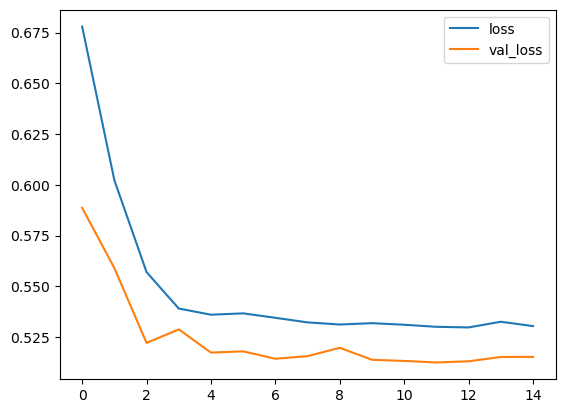

In [47]:
pd.DataFrame(autoencoder.history.history).plot()

Looks really good

In [54]:
# combine the testing data
X_test = np.concatenate([X_normal_test, X_fraud_scaled], axis=0)
y_test = np.concatenate([np.zeros(X_normal_test.shape[0]), np.ones(X_fraud_scaled.shape[0])], axis=0)
# predict and count error
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

1793/1793 [==============================] - 3s 2ms/step


In [55]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, mse)
roc_auc

0.9528253187056781

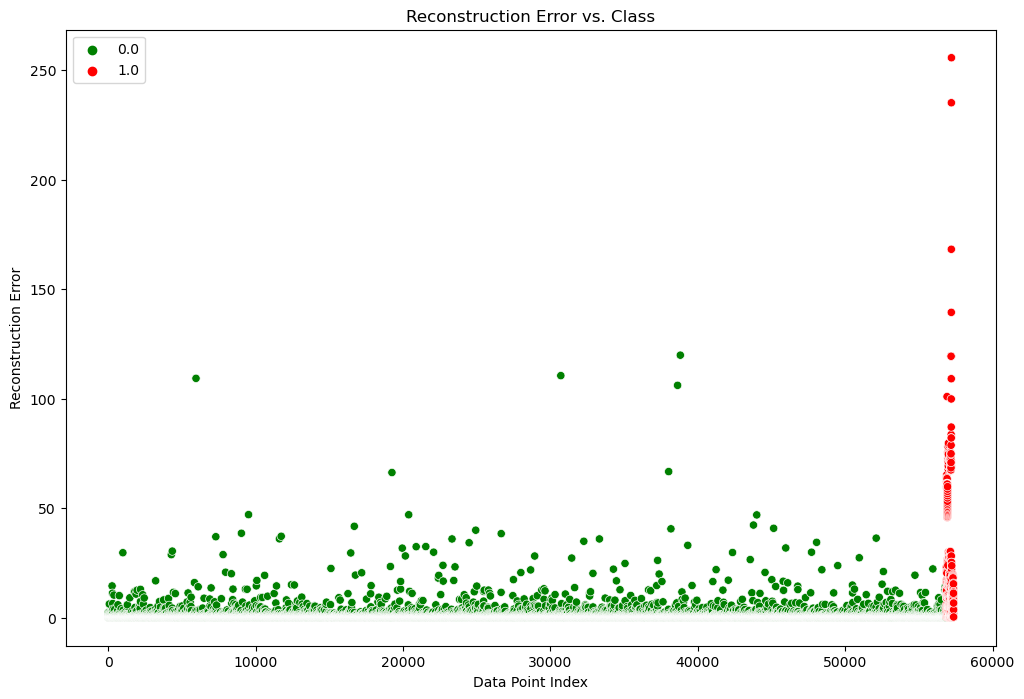

In [57]:
# data visualize
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x=range(len(mse)), y=mse, hue=y_test, palette={0: 'g', 1: 'r'})
plt.title('Reconstruction Error vs. Class')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.show()